Goal of this iteration is to learn an accurate predictive model of all input variables, in as little wall clock time as possible

- Use a better optimiser (ADAM)


In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch

env = gym.make('CartPole-v1')

print("Action Space: ", env.action_space)
print("Obs Space: ", env.observation_space)


SEED = 0
torch.manual_seed(SEED)


Action Space:  Discrete(2)
Obs Space:  Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


In [94]:
# Input -> state, action

# Output (all_preds)
# reward_model(state, action) -> reward
# env_model(state, action) -> next_state, done
# q_value(state, action) -> val
# policy(state) -> next_action

W = torch.normal(0,1,size=(5,8)) # reward (1), next_state (4), done (1), val (1), next_action (1)

loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam([W], lr=0.1, amsgrad=False)
# optimizer = torch.optim.SGD([W], lr=0.1)

params = [W]

for p in params:
    p.requires_grad = True


In [95]:
import random

class ReplayBuffer:
    def __init__(self, max_len=1e6):
        self.buffer = []
        self.max_len = int(max_len)
    
    def append(self, state_transition):
        if len(self.buffer) >= self.max_len:
            self.buffer.pop(0)
        self.buffer.append(state_transition) #(state, action, reward, next_state, done)
    
    def sample(self, batch_size):
        
        batch_size = min(batch_size, len(self.buffer))

        if batch_size == 0:
            return torch.empty(0), torch.empty(0), torch.empty(0), torch.empty(0), torch.empty(0)
        
        data = random.sample(self.buffer, batch_size)
    
        # Assuming state_transition is a tuple (state, action, reward, next_state, done)
        states, actions, rewards, next_states, dones = zip(*data)
        
        # Converting to torch tensors
        states = torch.tensor(states, dtype=torch.float32) 
        actions = torch.tensor(actions, dtype=torch.float32).reshape(-1,1)
        rewards = torch.tensor(rewards, dtype=torch.float32).reshape(-1,1)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32).reshape(-1,1)

        return states, actions, rewards, next_states, dones
    
    def combine(self, sample, recent_transition):

        stack = None
        return stack

    def __len__(self):
        return len(self.buffer)

# Example usage
# buffer = ReplayBuffer(max_len=10000)
# buffer.append((state, action, reward, next_state, done))
# batch = buffer.sample(32)

replay_buffer = ReplayBuffer()

In [100]:
next_state, info = env.reset(seed=SEED)
# next_action = env.action_space.sample()
next_action = random.choice([-1, 1])

losses = []  # List to store loss values
actual_history = [[] for _ in range(4)]
pred_history = [[] for _ in range(4)]

In [101]:
for _ in range(100):

    # Combine state, action, reward from current and past experince
    state = next_state
    action = next_action

    x = torch.zeros(size=(1,5)) # 4 obs, 1 action,
    x[0,:4] = torch.tensor(state, dtype=torch.float32)
    x[0,4] = torch.tensor([action], dtype=torch.float32)

    data = replay_buffer.sample(1000)
    state_action_stacked = torch.cat((data[0], data[1]), dim=1)
    x_stacked = torch.cat((x, state_action_stacked))

    # forward pass - make prediction
    y = x_stacked @ W

    # extract
    pred_reward = y[:, 0]
    pred_state = y[:, 1:5]
    pred_done = y[:, 5]
    pred_value = y[:, 6]
    # next_action = y[:, 7]
    next_action = random.choice([-1, 1])

    # Enviroment step
    if int(action) == -1:
        a = 0
    else:
        a = 1
    next_state, reward, terminated, truncated, info = env.step(a)
    if terminated or truncated:
        done = True
    else:
        done = False

    # Add experince to replay
    replay_buffer.append((state, action, reward, next_state, done))

    # Update value model, enviroment model, etc..
    actual_state = torch.tensor(next_state).reshape(1,-1)
    actual_state_stacked = torch.cat((actual_state, data[3]))
    

    loss = loss_func(pred_state, actual_state_stacked)
    # loss = loss_func(pred_state[0:,:], actual_state_stacked[0:,:])

    #backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Logging
    losses.append(loss.item())
    print(f"Loss: {loss.item():0.6f}")

    for i in range(4):
        actual_history[i].append(actual_state[0, i].item())
        pred_history[i].append(pred_state[0, i].item())
    
    # Done checking
    if done:
        for i in range(4):
            actual_history[i].append(np.nan)
            pred_history[i].append(np.nan)
        next_state, info = env.reset(seed=SEED)
        #TODO, ge1000t a better action here

Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.000001
Loss: 0.00

In [ ]:
env.close()

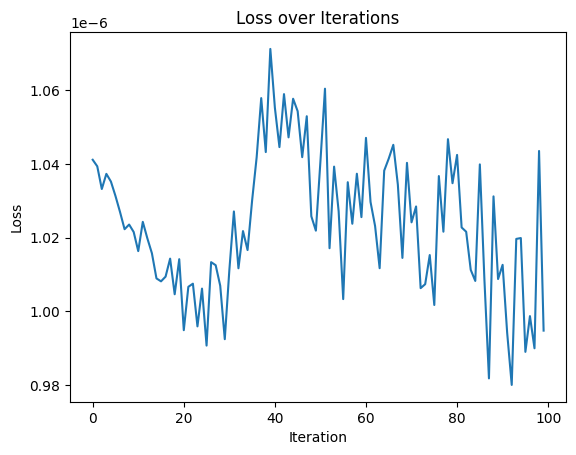

In [102]:
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss over Iterations')
plt.show()

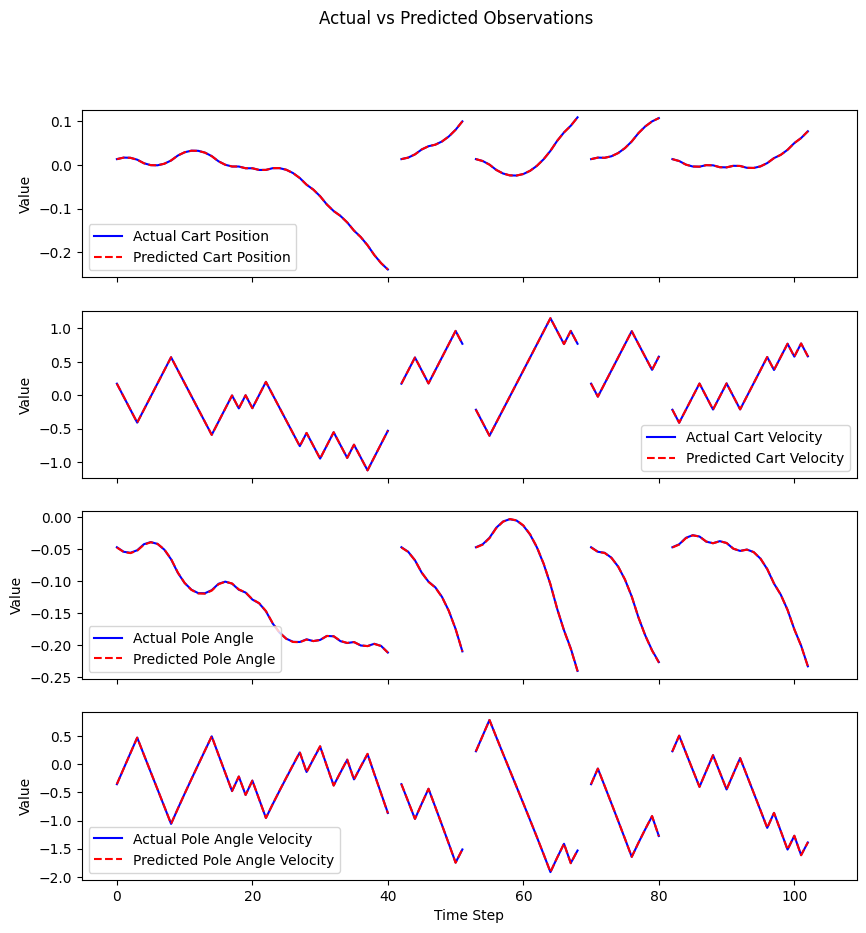

In [103]:
# Create subplots for each set of predicted and actual values
fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

legend_labels = {
    1: 'Cart Position',
    2: 'Cart Velocity',
    3: 'Pole Angle',
    4: 'Pole Angle Velocity'
}

# Plot actual and predicted values for each set
for i in range(4):
    axs[i].plot(actual_history[i], color='blue', linestyle='-', label=f'Actual {legend_labels[i+1]}')
    axs[i].plot(pred_history[i], color='red', linestyle='--', label=f'Predicted {legend_labels[i+1]}')
    axs[i].set_ylabel('Value')
    axs[i].legend()

# Add labels and title
axs[-1].set_xlabel('Time Step')
plt.suptitle('Actual vs Predicted Observations')

# Show the plot
plt.show()

In [106]:
print(x_stacked[0,:].numpy())
# print(x.numpy())
w_manual = torch.tensor([0, 1, 0, 0, 0.19])
print(W[:,1].detach().numpy())
y =  x @ W
print(y)
print(x[0,:]@W[:,1])
print(x[0,:]@w_manual)

W_max = torch.max(torch.abs(W.detach()), axis=0)[0]
print(W_max)
W_normalized = W / W_max
print(W_normalized[:,0])

[ 0.01369617 -0.02302133 -0.04590265 -0.04834723 -1.        ]
[ 1.0024804e+00  1.8943004e-02  3.0944170e-03 -7.7610725e-04
 -7.3368216e-07]
tensor([[ 1.2906,  0.0132, -0.2174, -0.0472,  0.2285,  2.2099, -1.5661,  1.2722]],
       grad_fn=<MmBackward0>)
tensor(0.0132, grad_fn=<DotBackward0>)
tensor(-0.2130)
tensor([1.5771, 1.0025, 0.9996, 1.0226, 1.0005, 2.2357, 1.4660, 1.3482])
tensor([-0.5750,  0.5027, -1.0000, -0.0819, -0.7879],
       grad_fn=<SelectBackward0>)


Text(0, 0.5, 'Rows')

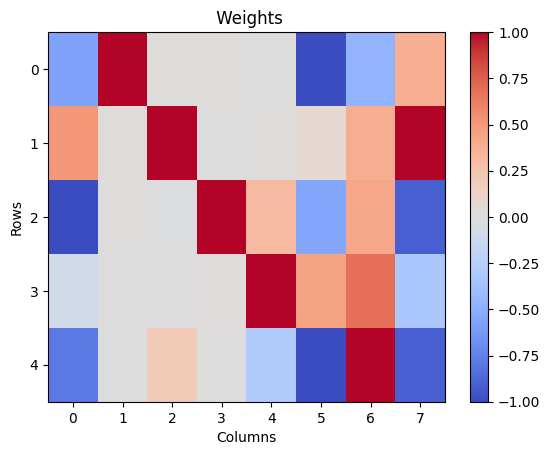

In [105]:
# plt.subplot(1, 2, 1)
plt.title(" Weights")
plt.imshow(W_normalized.detach().numpy(), cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.xlabel('Columns')
plt.ylabel('Rows')